# Evaluating model and interpret the classification results

In [21]:
import torchray
import torch
import attr
from pathlib import Path
from torchvision import datasets, transforms
from torchray.benchmark import get_example_data, plot_example
from torchvision import models
import torchvision
import matplotlib.pyplot as plt

In [22]:
@attr.s(auto_attribs=True)
class DataPreparation:
    data_dir: Path
    device: str = attr.ib(default=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), init=False)

    @staticmethod
    def data_transformations():
        data_transforms = {
            'test': transforms.Compose([
                transforms.CenterCrop((200, 1500)),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        return data_transforms
    
    def create_dataloaders(self, batch_size, shuffle, num_workers):
        data_transforms = self.data_transformations()
        
        image_datasets = {
            'test': datasets.ImageFolder(self.data_dir, data_transforms['test'])
        }
        dataloaders = {
            'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        }
        dataset_sizes = {
            'test': len(image_datasets['test'])
        }
        return dataloaders, dataset_sizes


In [47]:
data_prep = DataPreparation('../data/figures/test')
data, size = data_prep.create_dataloaders(16, False, 4)

In [48]:
#model_path = Path().cwd().parents[0] / "models/resnet50_d_28_t_15_49.pth"
model_path = Path().cwd().parents[0] / "models/resnet50_d_29_t_02_34.pth"

In [49]:
model = torch.load(model_path)
model.eval();

In [50]:
from torchray.attribution.common import Probe, get_module
from torchray.attribution.grad_cam import grad_cam
from torchray.attribution.grad_cam import gradient_to_grad_cam_saliency

In [51]:
def deprocess(image):
    transform = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [ ]:
i = 0
for inputs, labels in data['test']:
    inputs = inputs.to(0)
    labels = labels.to(0)
    x = inputs
    x.requires_grad_();
    scores = model(x)
    score_max_index = scores.argmax(dim=1)
    score_max = scores[:, score_max_index]
    score_max.backward(torch.ones_like(score_max))
    saliency, _ = torch.max(x.grad.data.abs(),dim=1)
    
    for index in range(len(saliency)): 
        plt.figure()
        img1 = plt.imshow(saliency[index].cpu().numpy(), cmap=plt.cm.hot, alpha=.7);
        img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4);
        plt.axis('off')
        plt.savefig(f"../saliency_maps/{i}_{index}.png")
        
    i += 1

In [29]:
x.size()

torch.Size([4, 3, 224, 224])

In [30]:
x.requires_grad_();
scores = model(x)

In [31]:
print(f"Scores\tLabels\n{scores}\t{labels}")

Scores	Labels
tensor([[ 3.1073, -3.1073],
        [ 4.0947, -4.0946],
        [ 4.1579, -4.1579],
        [ 3.5024, -3.5024]], device='cuda:0', grad_fn=<AddmmBackward>)	tensor([0, 0, 0, 0], device='cuda:0')


In [32]:
score_max_index = scores.argmax(dim=1)
print(f"SCORE MAX INDEX: {score_max_index}")
score_max = scores[:, score_max_index]
print(f"SCORE MAX: {score_max}")

'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward(torch.ones_like(score_max))
# score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(x.grad.data.abs(),dim=1)

SCORE MAX INDEX: tensor([0, 0, 0, 0], device='cuda:0')
SCORE MAX: tensor([[3.1073, 3.1073, 3.1073, 3.1073],
        [4.0947, 4.0947, 4.0947, 4.0947],
        [4.1579, 4.1579, 4.1579, 4.1579],
        [3.5024, 3.5024, 3.5024, 3.5024]], device='cuda:0',
       grad_fn=<IndexBackward>)


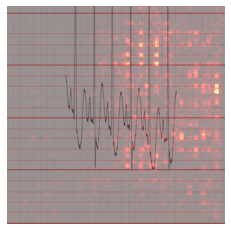

In [42]:
index = 0
# code to plot the saliency map as a heatmap
plt.figure()
img1 = plt.imshow(saliency[index].cpu().numpy(), cmap=plt.cm.hot, alpha=.7)
# plt.axis('off')
# plt.show()
img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4)
plt.axis('off')
plt.show()

In [14]:
saliency[index].mean()

tensor(5.0408e-10, device='cuda:0')

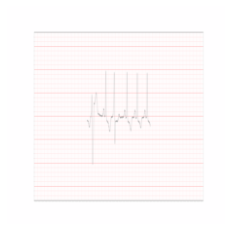

In [15]:
img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4)
plt.axis('off')
plt.show()

In [64]:
saliency_layer = get_module(model, model.avgpool)
probe = Probe(saliency_layer, target='output')
y = model(x)
z = y[0, labels[0]]
z.backward();

In [59]:
print(model.children)

<bound method Module.children of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256

torch.Size([4, 2048, 7, 7])
tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],


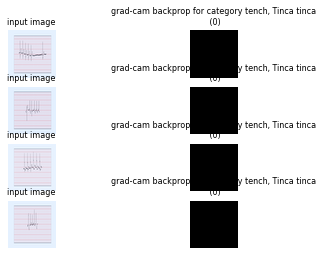

In [65]:
print(probe.data[0].size())
saliency = gradient_to_grad_cam_saliency(probe.data[0])
# Plots.
plot_example(x, saliency, 'grad-cam backprop', labels, save_path='saliency.pdf')

In [17]:
# Grad-CAM backprop.
saliency = grad_cam(model, x, labels, saliency_layer=model.layer4)

# Plots.
# plot_example(x, saliency, 'grad-cam backprop', labels)

print(saliency.size())

plt.imshow(deprocess(saliency[index]).cpu().detach().numpy())
plt.axis('off')
plt.show()

torch.Size([4, 1, 7, 7])


RuntimeError: output with shape [1, 7, 7] doesn't match the broadcast shape [3, 7, 7]